In [1]:
import numpy as np
import math
import scipy.constants as sc
import matplotlib.pyplot as plt
from pygmid import Lookup as lk

/home/mthudaa/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
choice = 1  #start from 0
devices = ['nfet_01v8_lvt', 'nfet_01v8', 'pfet_01v8_lvt', 'pfet_01v8']
nfet = lk('sky130/simulation/'+devices[choice]+'.mat')
pfet = lk('sky130/simulation/'+devices[choice+2]+'.mat')

In [3]:
# sweep variable vectors
nl = nfet['L']
nvgs = nfet['VGS']
nvds = nfet['VDS']
nvsb = nfet['VSB']

# sweep variable vectors
pl = pfet['L']
pvgs = pfet['VGS']
pvds = pfet['VDS']
pvsb = pfet['VSB']

In [4]:
# %% [markdown]
# # Perhitungan Desain Saklar Track and Hold untuk SAR ADC
#
# Program ini membantu menghitung parameter desain awal untuk saklar T/H
# berdasarkan teknologi CMOS 130nm, frekuensi sampling 1.9 MHz, dan suplai 1.8V.
# Referensi metodologi diadaptasi dari paper oleh B. Razavi.

# %% [markdown]
# ## 1. Parameter Input dan Konstanta

# %%
# --- Konstanta Fisika ---
k_boltzmann = 1.380649e-23  # J/K (Konstanta Boltzmann)
T_kelvin = 300  # K (Suhu ruangan, sekitar 27 C)

# --- Spesifikasi ADC dan Teknologi ---
V_DD = 1.8  # V (Tegangan Suplai)
fs = 1.9e6  # Hz (Frekuensi Sampling)
N_bits = 10  # bit (Resolusi ADC Target)
V_ref = 1.8 # V (Tegangan Referensi ADC)
V_in_min = 0.0 # V (Tegangan Input Minimum)
V_in_max = 1.8 # V (Tegangan Input Maksimum)

# --- Parameter Teknologi CMOS 130nm (Estimasi, gunakan nilai dari PDK Anda) ---
k_prime_n = 300e-6  # A/V^2 (mu_n * Cox untuk NMOS)
V_th_n = 0.45  # V (Tegangan Threshold NMOS)
L_min = 0.13e-6  # m (Panjang Kanal Minimum)
C_ox = k_prime_n / (250e-4 * (100**2)) # Estimasi Cox dari k_prime_n (misal mu_n ~ 250 cm^2/Vs)
                                     # Ini hanya estimasi kasar, Cox = epsilon_ox / t_ox
                                     # Lebih baik jika Anda memiliki nilai C_ox per area langsung dari PDK
# Misal, untuk t_ox ~ 2.5nm, Cox ~ 13.8 fF/um^2 = 1.38e-2 F/m^2
if C_ox > 5e-2 or C_ox < 1e-3 : # Jika estimasi Cox ngawur, gunakan nilai tipikal
    C_ox_per_area = 1.3e-2 # F/m^2 (Kapasitansi Oksida Gerbang per unit area, misal 13 fF/um^2)
else:
    C_ox_per_area = C_ox


# --- Target Desain ---
SNR_penalty_dB = 1.0  # dB (Penalti SNR yang diinginkan karena kT/C noise)
target_HD3_dB = -65 # dB (Target Distorsi Harmonik ke-3)
attenuation_target_dB = -0.5 # dB (Target atenuasi sinyal maksimum)



In [5]:
# %% [markdown]
# ## 2. Perhitungan Turunan dari Parameter Input

# %%
T_clk = 1 / fs  # s (Periode Clock)
t_acq_ratio = 0.5 # Rasio waktu akuisisi terhadap periode clock
t_acq = t_acq_ratio * T_clk  # s (Waktu Akuisisi, misal 50% dari T_clk)
delta_LSB = V_ref / (2**N_bits)  # V (Ukuran LSB)
A_signal_peak = (V_in_max - V_in_min) / 2 # V (Amplitudo puncak sinyal AC efektif)
f_in_max_nyquist = fs / 2 # Hz (Frekuensi input maksimum pada Nyquist)
omega_in_max_nyquist = 2 * math.pi * f_in_max_nyquist # rad/s

print(f"--- Parameter Turunan ---")
print(f"Periode Clock (T_clk): {T_clk*1e9:.2f} ns")
print(f"Waktu Akuisisi Target (t_acq): {t_acq*1e9:.2f} ns")
print(f"Ukuran LSB (delta_LSB): {delta_LSB*1e3:.3f} mV")
print(f"Amplitudo Puncak Sinyal (A_signal_peak): {A_signal_peak:.2f} V")
print(f"Frekuensi Input Nyquist (f_in_max): {f_in_max_nyquist/1e6:.2f} MHz")



--- Parameter Turunan ---
Periode Clock (T_clk): 526.32 ns
Waktu Akuisisi Target (t_acq): 263.16 ns
Ukuran LSB (delta_LSB): 1.758 mV
Amplitudo Puncak Sinyal (A_signal_peak): 0.90 V
Frekuensi Input Nyquist (f_in_max): 0.95 MHz


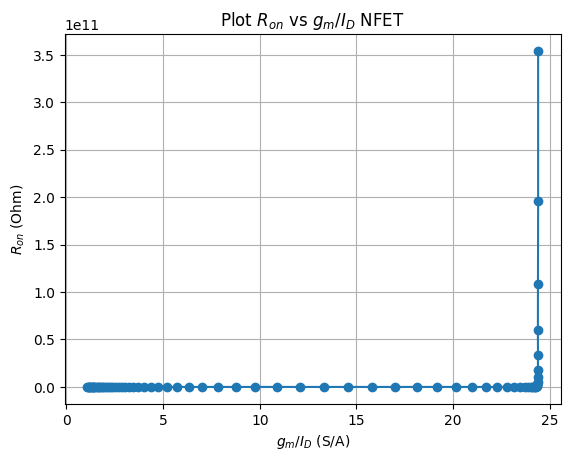

In [6]:
# Estimasi ukuran W dan L untuk saklar T/H
ngm_id = nfet.lookup('GM_ID', L=min(nl), VDS=0.9, VSB=0)
ngds = nfet.lookup('GDS', L=min(nl), VDS=0.9, VSB=0)
nron = 1 / ngds  # Resistansi On dari GDS
plt.figure()
plt.plot(ngm_id, nron, marker='o')
plt.xlabel('$g_m/I_D$ (S/A)')
plt.ylabel('$R_{on}$ (Ohm)')
plt.title('Plot $R_{on}$ vs $g_m/I_D$ NFET')
plt.grid(True)
plt.show()

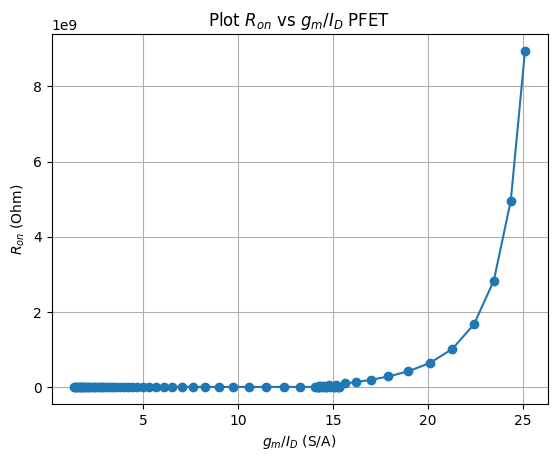

In [7]:
# Estimasi ukuran W dan L untuk saklar T/H
pgm_id = pfet.lookup('GM_ID', L=min(pl), VDS=0.9, VSB=0)
pgds = pfet.lookup('GDS', L=min(pl), VDS=0.9, VSB=0)
pron = 1 / pgds  # Resistansi On dari GDS
plt.figure()
plt.plot(pgm_id, pron, marker='o')
plt.xlabel('$g_m/I_D$ (S/A)')
plt.ylabel('$R_{on}$ (Ohm)')
plt.title('Plot $R_{on}$ vs $g_m/I_D$ PFET')
plt.grid(True)
plt.show()

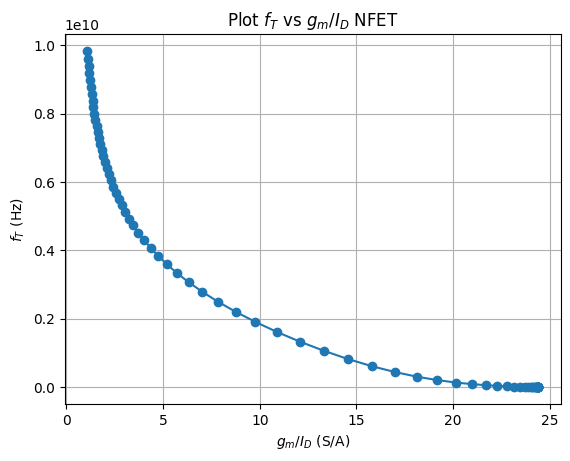

In [8]:
# Estimasi ukuran W dan L untuk saklar T/H
ngm_id = nfet.lookup('GM_ID', L=min(nl), VDS=0.9, VSB=0)
ngds = nfet.lookup('GDS', L=min(nl), VDS=0.9, VSB=0)
ncgg = nfet.lookup('CGG', L=min(nl), VDS=0.9, VSB=0)
nft = ngds/(2 * math.pi * ncgg)  # Resistansi On dari GDS
plt.figure()
plt.plot(ngm_id, nft, marker='o')
plt.xlabel('$g_m/I_D$ (S/A)')
plt.ylabel('$f_{T}$ (Hz)')
plt.title('Plot $f_{T}$ vs $g_m/I_D$ NFET')
plt.grid(True)
plt.show()

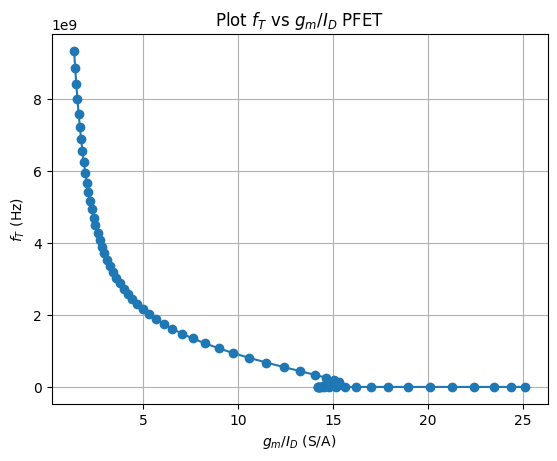

In [9]:
# Estimasi ukuran W dan L untuk saklar T/H
pgm_id = pfet.lookup('GM_ID', L=min(pl), VDS=0.9, VSB=0)
pgds = pfet.lookup('GDS', L=min(pl), VDS=0.9, VSB=0)
pcgg = pfet.lookup('CGG', L=min(pl), VDS=0.9, VSB=0)
pft = pgds/(2 * math.pi * pcgg)  # Resistansi On dari GDS
plt.figure()
plt.plot(pgm_id, pft, marker='o')
plt.xlabel('$g_m/I_D$ (S/A)')
plt.ylabel('$f_{T}$ (Hz)')
plt.title('Plot $f_{T}$ vs $g_m/I_D$ PFET')
plt.grid(True)
plt.show()

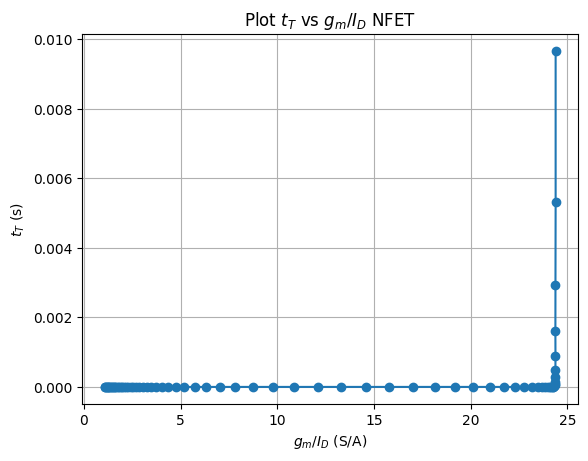

In [10]:
# Estimasi ukuran W dan L untuk saklar T/H
ngm_id = nfet.lookup('GM_ID', L=min(nl), VDS=0.9, VSB=0)
ngds = nfet.lookup('GDS', L=min(nl), VDS=0.9, VSB=0)
ncgg = nfet.lookup('CGG', L=min(nl), VDS=0.9, VSB=0)
nft = ngds/(2 * math.pi * ncgg)  # Resistansi On dari GDS
ntt = 1 / nft  # Waktu transit
plt.figure()
plt.plot(ngm_id, ntt, marker='o')
plt.xlabel('$g_m/I_D$ (S/A)')
plt.ylabel('$t_{T}$ (s)')
plt.title('Plot $t_{T}$ vs $g_m/I_D$ NFET')
plt.grid(True)
plt.show()

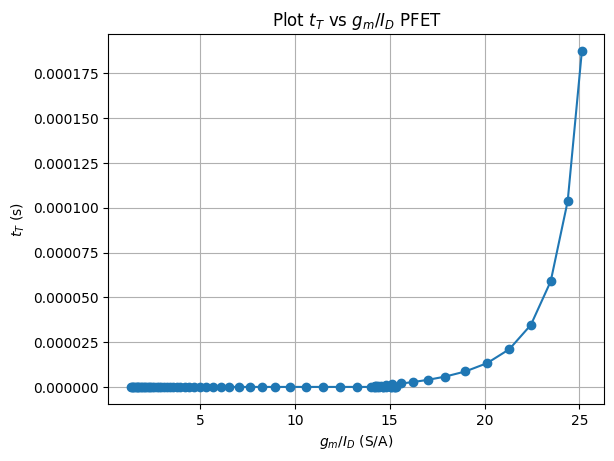

In [11]:
# Estimasi ukuran W dan L untuk saklar T/H
pgm_id = pfet.lookup('GM_ID', L=min(pl), VDS=0.9, VSB=0)
pgds = pfet.lookup('GDS', L=min(pl), VDS=0.9, VSB=0)
pcgg = pfet.lookup('CGG', L=min(pl), VDS=0.9, VSB=0)
pft = pgds/(2 * math.pi * pcgg)  # Resistansi On dari GDS
ptt = 1 / pft  # Waktu transit
plt.figure()
plt.plot(pgm_id, ptt, marker='o')
plt.xlabel('$g_m/I_D$ (S/A)')
plt.ylabel('$t_{T}$ (s)')
plt.title('Plot $t_{T}$ vs $g_m/I_D$ PFET')
plt.grid(True)
plt.show()

In [14]:
# sizing cdac switch based on curent densityz
# Cari nilai gm/id di mana tt = 1 ns (1e-9 s)
target_tt = 0.01e-9
nidx_tt = (np.abs(ntt - target_tt)).argmin()
ngm_id_tt = ngm_id[nidx_tt]
pidx_tt = (np.abs(ptt - target_tt)).argmin()
pgm_id_tt = pgm_id[pidx_tt]
print(f"Nilai gm/id NMOS saat t_T ≈ 1 ns: {ngm_id_tt:.4f} S/A (tt = {ntt[nidx_tt]:.2e} s)")
print(f"Nilai gm/id PMOS saat t_T ≈ 1 ns: {pgm_id_tt:.4f} S/A (tt = {ptt[pidx_tt]:.2e} s)")
# Cari nilai Id/W pada nilai gm/id yang ditentukan
nid_w = nfet.lookup('ID_W', GM_ID=ngm_id_tt, L=min(nl), VDS=0.9, VSB=0)
pid_w = pfet.lookup('ID_W', GM_ID=pgm_id_tt, L=min(pl), VDS=0.9, VSB=0)
print(f"Nilai Id/W NMOS pada gm/id ≈ {ngm_id_tt:.4f} S/A: {nid_w * 1e6:.2f} uA/um")
print(f"Nilai Id/W PMOS pada gm/id ≈ {pgm_id_tt:.4f} S/A: {pid_w * 1e6:.2f} uA/um")
for i in range(0, 10):
    nw = (((2**i * 9.54e-15 * 4) * (V_ref/2))/0.5e-9)/nid_w
    pw = (((2**i * 9.54e-15 * 4) * (V_ref/2))/0.5e-9)/pid_w
    print(f"Bit ke-{i} :")
    print(f"    Lebar W NMOS : {round(nw,1)} um")
    print(f"    Lebar W PMOS : {round(pw,1)} um")
    

Nilai gm/id NMOS saat t_T ≈ 1 ns: 1.0793 S/A (tt = 1.02e-10 s)
Nilai gm/id PMOS saat t_T ≈ 1 ns: 1.3597 S/A (tt = 1.07e-10 s)
Nilai Id/W NMOS pada gm/id ≈ 1.0793 S/A: 430.89 uA/um
Nilai Id/W PMOS pada gm/id ≈ 1.3597 S/A: 138.79 uA/um
Bit ke-0 :
    Lebar W NMOS : 0.2 um
    Lebar W PMOS : 0.5 um
Bit ke-1 :
    Lebar W NMOS : 0.3 um
    Lebar W PMOS : 1.0 um
Bit ke-2 :
    Lebar W NMOS : 0.6 um
    Lebar W PMOS : 2.0 um
Bit ke-3 :
    Lebar W NMOS : 1.3 um
    Lebar W PMOS : 4.0 um
Bit ke-4 :
    Lebar W NMOS : 2.6 um
    Lebar W PMOS : 7.9 um
Bit ke-5 :
    Lebar W NMOS : 5.1 um
    Lebar W PMOS : 15.8 um
Bit ke-6 :
    Lebar W NMOS : 10.2 um
    Lebar W PMOS : 31.7 um
Bit ke-7 :
    Lebar W NMOS : 20.4 um
    Lebar W PMOS : 63.3 um
Bit ke-8 :
    Lebar W NMOS : 40.8 um
    Lebar W PMOS : 126.7 um
Bit ke-9 :
    Lebar W NMOS : 81.6 um
    Lebar W PMOS : 253.4 um
